<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA
</center></font>


<center><h2>Proyecto 2</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: _______</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>


In [ ]:
from IPython.display import IFrame, display
#filepath = "Proyecto_2_EIE401.pdf"
#IFrame(filepath, width=700, height=400)

En la dirección https://huggingface.co/datasets/astroboy1/metasurfaces_V1_30-90GHZ encontrarás el archivo batch_june2024.zip que contiene las imagenes que usarás para el procesamiento. ATENCION: usa el archivo zip indicado pues tienes las imagenes preparadas para tu trabajo.

## 1. Carga de Datos


- En los archivos, encontrarás un folder con imagenes de 3 categorías: cross, box, circle.
Cada imagen tiene una medida de 512x512 pixeles y 3 canales. Se han acentuado los azules y rojos para facilitar el proceso de obtención de características.

- Puedes extraer la clase a la que pertenece la imagen, desde el nombre del archivo. Ahí mismo encuentras números de serie que te permiten identificar de forma específica una imagen.

- Se te entrega 3 imagenes de referencia de 32x32 pixeles, las que debes usar como plantilla para el proceso de clasificación de la imagen.


##Librerias

In [1]:
import zipfile
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from multiprocessing import Pool
import shutil
import pywt
from timeit import default_timer as timer


In [2]:
#URL de descarga del archivo zip
url = "https://huggingface.co/datasets/astroboy1/metasurfaces_V1_30-90GHZ/resolve/main/batch_june2024.zip"

#Nombramos al archivo zip
zip = "batch_june2024.zip"

#Descargamos el archivo zip
response = requests.get(url)
with open(zip, "wb") as f:
    f.write(response.content)
print("Archivo Zip Descargado")

#Descomprimimos en el directorio
with zipfile.ZipFile(zip, 'r') as zip_ref:
    zip_ref.extractall(".")
print("Archivo Zip descomprimido")


Archivo Zip Descargado
Archivo Zip descomprimido


In [3]:
#Nombramos la ruta de las fotos
original = "processed512"

#Creamos la carpeta para las imagenes procesadas
procesadas = "128pix"
os.makedirs(procesadas, exist_ok=True)

tareas = []
for imagen in os.listdir(original):
    if imagen.endswith(('.png')):
        tareas.append((original, procesadas, imagen))

def procesarImagen(args):
    original, procesadas, imagen = args
    rutaOriginal = os.path.join(original, imagen)
    rutaFinal = os.path.join(procesadas, imagen)
    imagen = cv2.imread(rutaOriginal)
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    imagen = cv2.resize(imagen, (128, 128))
    cv2.imwrite(rutaFinal, imagen)

#Procesamiento paralelo
with Pool(processes=4) as pool:
    pool.map(procesarImagen, tareas)

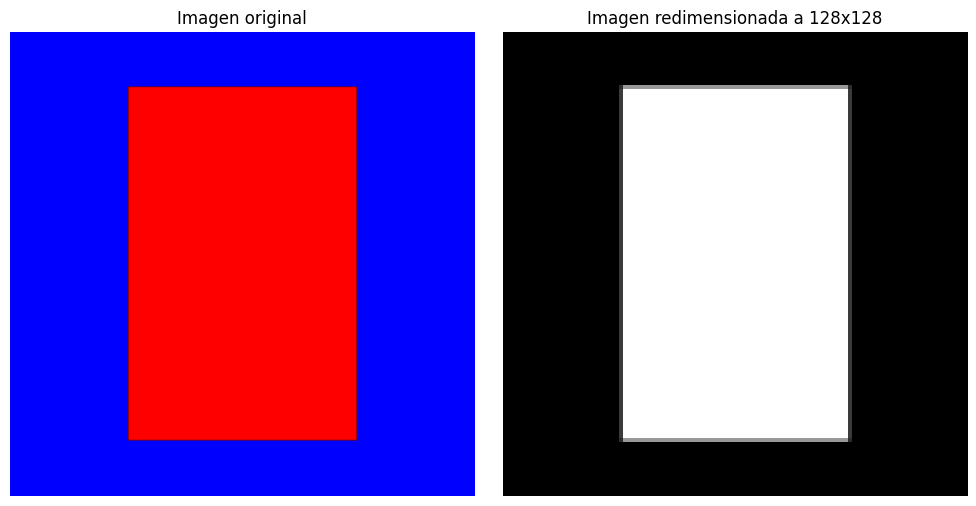

In [4]:
#Ruta de las imagen original y redimensionada
imgOr = "processed512/box_01_freq_reflect_0ed3a0e8-a653-11ee-9db6-047c16a08772_0-30_80-90.png"
imgRe = "128pix/box_01_freq_reflect_0ed3a0e8-a653-11ee-9db6-047c16a08772_0-30_80-90.png"

#Leemos las imagenes
imagenOr = cv2.imread(imgOr)  #En BGR
imagenRe = cv2.imread(imgRe, cv2.IMREAD_GRAYSCALE)  #En escala de grises

#Mostramos las imagenes originales y procesadas
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(imagenOr, cv2.COLOR_BGR2RGB))
plt.title("Imagen original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(imagenRe, cmap="gray")
plt.title("Imagen redimensionada a 128x128")
plt.axis("off")

plt.tight_layout()
plt.show()


In [5]:
#Creamos carpeta template en caso de no existir
os.makedirs("templates", exist_ok=True)

#Archivos template a mover
archivos = ["box_template.png", "circ_template.png", "cross_template.png"]

#Verificamos que esten los archivos en la carpeta, si no, los movemos
archivosTemplate = all(os.path.exists(os.path.join("templates", archivo)) for archivo in archivos)

if archivosTemplate:
    print("Los archivos ya se encuentran en la carpeta 'templates', por lo que no se realizara ninguna acción")
else:
    for archivo in archivos:
        destino = os.path.join("templates", archivo)
        if not os.path.exists(destino):
            shutil.move(archivo, destino)
            print(f"{archivo} movido a 'templates'")


Los archivos ya se encuentran en la carpeta 'templates', por lo que no se realizara ninguna acción


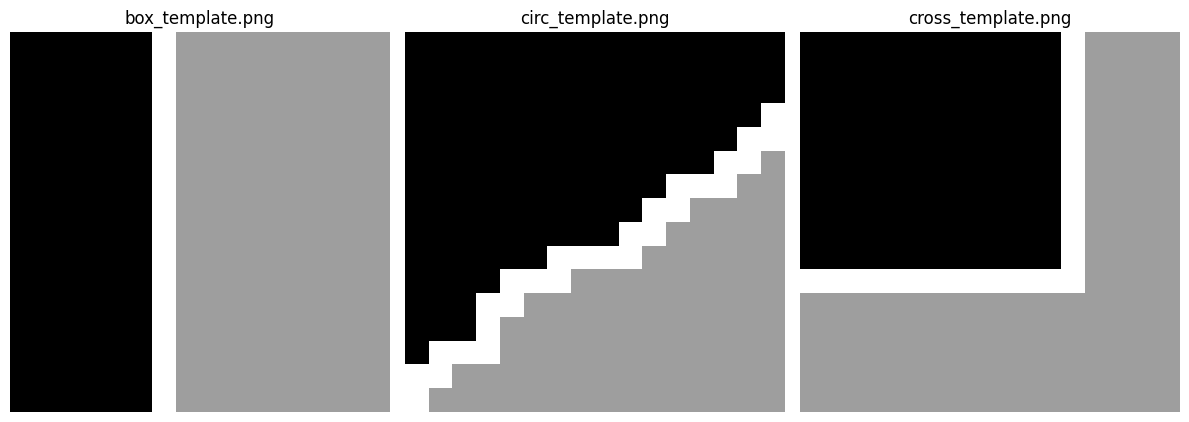

In [6]:
#Mostramos las imagenes en templates
plt.figure(figsize=(12, 5))
for idx, archivo in enumerate(archivos):
    ruta = os.path.join("templates", archivo)
    imagen = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)  #Leemos en escala de grises
    plt.subplot(1, len(archivos), idx + 1)
    plt.imshow(imagen, cmap="gray")
    plt.title(archivo)
    plt.axis("off")

plt.tight_layout()
plt.show()

## 2. Transformar imagen
Recuerda que la tarea es lograr el procesamiento más rápido posible.
Para lograr esto, realiza las operaciones que consideres necesarias sobre la imagen original para el posterior trabajo de Matching con las plantillas dadas. Crees que trabajar en el dominio de fourier o wavelet ayudaría en las etapas posteriores?

In [8]:
#Definir carpeta con las wavelet
carpetaWavelet = "carpetaWave"
os.makedirs(carpetaWavelet, exist_ok=True)

#Obtenemos lista de imagenes
imagenes128pix = [img for img in os.listdir(procesadas) if img.endswith('.png')]

#Iteramos para procesar las imagenes redimensionadas
for nombre in imagenes128pix:
    ruta = os.path.join(procesadas, nombre)
    imagen = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)  #Escala de grises

    if imagen is not None:
        #Transformada wavelet
        coeffs2 = pywt.dwt2(imagen, 'haar')
        cA, (cH, cV, cD) = coeffs2

        #Normalizamos el coeficiente
        cANorm = cv2.normalize(cA, None, 0, 255, cv2.NORM_MINMAX)
        cANorm2 = cANorm.astype(np.uint8)
        salida = os.path.join(carpetaWavelet, nombre)
        cv2.imwrite(salida, cANorm2)






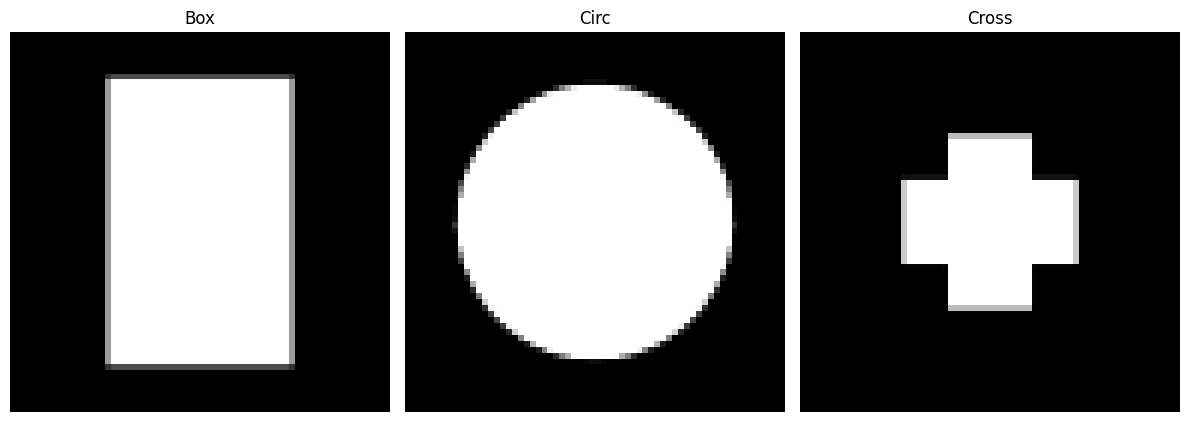

In [9]:
#Elegimos las imagenes con wavelet
imgEj = ["carpetaWave/box_01_freq_reflect_0ed3a0e8-a653-11ee-9db6-047c16a08772_0-30_80-90.png", "carpetaWave/circ_01_freq_reflect_bd00bd23-e53b-11ee-a555-047c16a08772_0-998_80-90.png", "carpetaWave/cross_01_freq_reflect_e9503ad7-c681-11ee-809f-047c16a08772_0-11_80-90.png"]

Nombs = ["Box", "Circ", "Cross"]

#Creamos el subplot
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

#Mostramos las imagenes con wavelet
for i, ruta in enumerate(imgEj):
    img = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(Nombs[i])

plt.tight_layout()
plt.show()



## 3. Operaciones
Para extraer las caracteristicas, debes realizar las operaciones de segmentación, normalización o convolución como creas necesarias.
El resultado de tus operaciones vas a usarlo para el proceso de matching.


In [10]:
#Definimos la carpeta de las imagenes template
temp = "templates"

#Procesamos las plantillas template con la wavelet
templatesWave = {}
for archivo in os.listdir(temp):
    if archivo.endswith('.png'):
        plantillas = os.path.join(temp, archivo)
        imgTemp = cv2.imread(plantillas, 0)

        if imgTemp is not None:
            #En cATemplate guardo los coeficientes para reconocer las imagenes
            cATemplate, _ = pywt.dwt2(imgTemp, 'haar')
            #Use .normalize para normalizar los resultados
            cATemplate = cv2.normalize(cATemplate, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            templatesWave[archivo] = cATemplate





## 4. Matching
El proceso de matching debe considerar que vas a usar las imagenes de referencia para calcular la correlación


Este proceso es similar a un windowing, donde la ventana es la imagen de referencia.
Como verás es un proceso iterativo, dispendioso, pero en el que puedes poner tu creatividad a funcionar para lograrlo de forma eficiente.

#### _TIP: realiza el proceso un batch pequeño de imagenes, o solo sobre un par de ellas, hasta que estés satisfecho con el resultado. Una vez esté listo, ESCALA el procedimiento para operar todas la imagenes lo más rápido posible.!_

In [11]:
#Realizamos el Match de imagenes
resultados = {}

umbral = 0.5  #Definimos el umbral para reducir falsos positivos

start = timer()
print(23*2.3)

for nombreImagen in os.listdir(carpetaWavelet):
    if nombreImagen.endswith('.png'):
        ruta = os.path.join(carpetaWavelet, nombreImagen)
        imagen = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)

        if imagen is None:
            continue

        #Puntaje minimo para asegurarnos de poder clasificarlo
        puntajeMin = -1
        mejorTemplate = None

        for nombrePlant, plantilla in templatesWave.items():
            if imagen.shape[0] >= plantilla.shape[0] and imagen.shape[1] >= plantilla.shape[1]:
                resultado = cv2.matchTemplate(imagen, plantilla, cv2.TM_CCOEFF_NORMED)
                _, max, _, _ = cv2.minMaxLoc(resultado)

                #Comprobamos si superamos el umbral
                if max > puntajeMin and max >= umbral:
                    puntajeMin = max
                    mejorTemplate = nombrePlant

        #Guardamos los resultados con el mayor parecido
        if mejorTemplate:
            resultados[nombreImagen] = {
                "template": mejorTemplate,
                "score": puntajeMin
            }
        else:
            resultados[nombreImagen] = {
                "template": "Sin coincidencia",
                "score": puntajeMin
            }


end = timer()
print(end - start)



52.9
6.970095536998997


# 5. Clasificación
De cada operación realizada de matching, obtendrás valores para inferir si la imagen bajo estudio corresponde con alguna de las 3 categorías: cross, box, circle.

Debes almacenar cada resultado obtenido para cada imagen, hallar el error de clasificación y generar un informe del error general al clasificar todas las imagenes.

Presenta aquí el resultado de clasificación numérico, así como  dos ejemplos verdaderos y dos ejemplos falsos de imagenes clasificadas.


In [12]:
#Definimos las variables para las imagenes bien y mal identificadas y para calcular resultados
imgBien = []
imgMal = []
aciertos = 0
total = 0
resultClas = []

#Revisamos los resultados anteriores
for nombreImagen, info in resultados.items():
    Templado = info["template"]
    puntajeMin = info["score"]

    #Extraemos los nombres antes del "_" para reconocer si es circle, cross o box
    templateReal = nombreImagen.split('_')[0].lower()
    templatePredicha = Templado.split('_')[0].lower() if Templado else ""

    acerte = templatePredicha == templateReal
    if acerte:
        aciertos += 1
        if len(imgBien) < 2:
            imgBien.append((nombreImagen, templateReal, templatePredicha, puntajeMin))
    else:
        if len(imgMal) < 2:
            imgMal.append((nombreImagen, templateReal, templatePredicha, puntajeMin))

    total += 1
    resultClas.append((nombreImagen, templateReal, templatePredicha, puntajeMin, acerte))

#Calculamos el porcentaje de error
error = (total - aciertos) /total*100

#Resultados
print("Resultados de la clasificación:\n")
print(f"Aciertos: {aciertos}/{total}")
print(f"Error del: {error:.2f}%")




Resultados de la clasificación:

Aciertos: 7215/14328
Error del: 49.64%


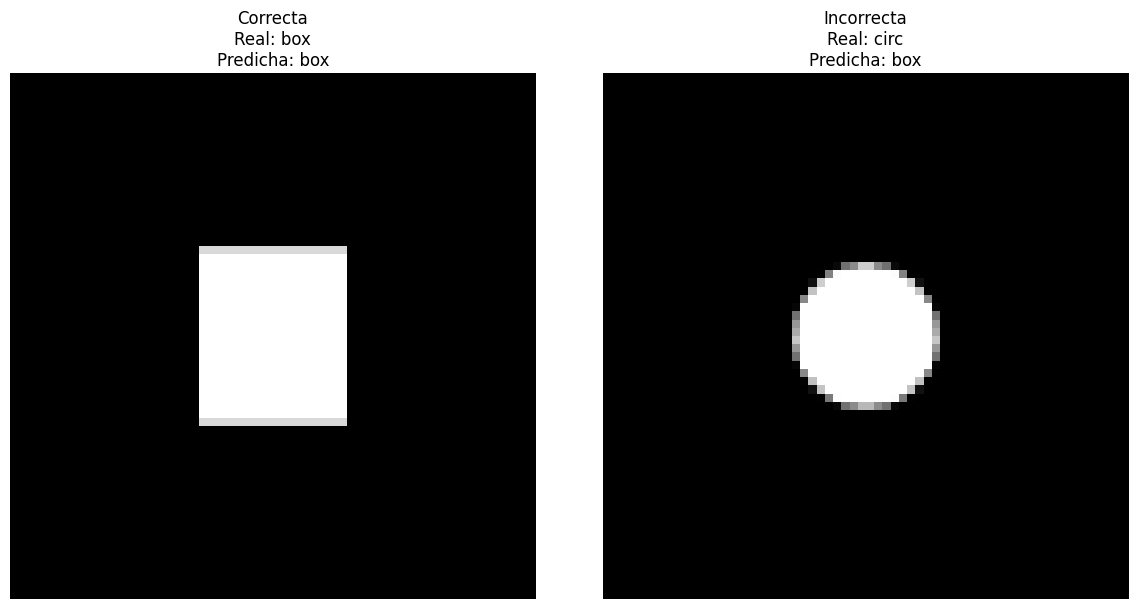

In [13]:
#carpeta donde están las imágenes procesadas
carpetaWavelet = "carpetaWave"

#Elegimos la imagen correcta
acert = imgBien[0][0]
acerta = os.path.join(carpetaWavelet, acert)
imgAcert = cv2.imread(acerta, cv2.IMREAD_GRAYSCALE)

#Elegimos la imagen incorrecta
incorrec = imgMal[0][0]
incorrect = os.path.join(carpetaWavelet, incorrec)
imgIncorrec = cv2.imread(incorrect, cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#Imagen acertada
axs[0].imshow(imgAcert, cmap='gray')
axs[0].set_title(f"Correcta\nReal: {imgBien[0][1]}\nPredicha: {imgBien[0][2]}")
axs[0].axis('off')

#Imagen incorrecta
axs[1].imshow(imgIncorrec, cmap='gray')
axs[1].set_title(f"Incorrecta\nReal: {imgMal[0][1]}\nPredicha: {imgMal[0][2]}")
axs[1].axis('off')

plt.tight_layout()
plt.show()


# 6. Medición
Recuerda que debes imprimir el tiempo que tarda tu algoritmo en procesar todas las imagenes en la base de datos. Usa el siguiente fragmento de código, ubicando el inicio y fin donde corresponda.





In [ ]:
from timeit import default_timer as timer

start = timer()

print(23*2.3)

end = timer()
print(end - start)

